# Introduction to *pyshtools* (Part 2): Localization windows and spectral analysis

Now that we know how to work with spherical harmonic coefficient and grid classes, let's move on to the other major feature of *pyshtools*: localization windows and spectral analysis. *pyshtools* allows for localized spectral analyses using either spherical-cap localization windows or localization windows constructed from an arbitrary map. As with our examples in Part 1, almost everything can be performed using a single class, `SHWindow`. Here, we will demonstrate how to construct optimal localization windows, and how to obtain localized spectral estimates for arbitrary regions on the sphere.


In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools

In this example, we will make use of a pathological data set. We construct a function on the sphere whose power spectrum is different in the northern and southern hemispheres.

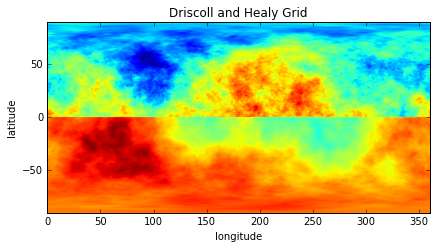

In [29]:
ldata = 200
degrees = np.arange(ldata+1, dtype=float)
degrees[0] = np.inf
power_north = degrees**(-2)
power_south = degrees**(-2.5)

clm_north = pyshtools.SHCoeffs.from_random(power_north)
grid_north = clm_north.expand()
clm_south = pyshtools.SHCoeffs.from_random(power_south)
grid_south = clm_south.expand()

nlat = grid_north.nlat
grid_north.data[nlat//2:nlat+1,:] = grid_south.data[nlat//2:nlat+1,:]

clm = grid_north.expand()
grid = clm.expand()
fig, ax = grid.plot_rawdata()

In this example, we made use of the grid attribute `nlat`, which is the number of rows of the gridded data, and we modified the raw gridded data for `grid_north` that is stored in the `data` class attribute.

Next, let's construct some spherical-cap localization windows. This is done using the constructor `from_cap()` that is associated with the `SHWindow` class. The other option, as we will demonstrate later, is `from_mask()` and takes as input a user defined masking function. For spherical-cap windows, we need to specify both the angular radius of the cap and its spherical harmonic bandwidth. For this example, we will use an angular radius of 30 degrees and a bandwidth of 29.

In [30]:
scapwin = pyshtools.SHWindow.from_cap(theta=30., lwin=29)

This command calculates the spherical harmonic coefficients of the tapers along with their associated angular orders and concentration factors. If you ever need to access these directly, they are stored in the class attributes `tapers`, `orders` and `eigenvalues.` By default, `theta` is provided in degrees, but this can be changed to radians by specifying the optional parameter `theta_degrees=False`. If you are curious to see what these windows look like, you can plot them using the built in method `plot_windows()`. Let's plot the first 35:

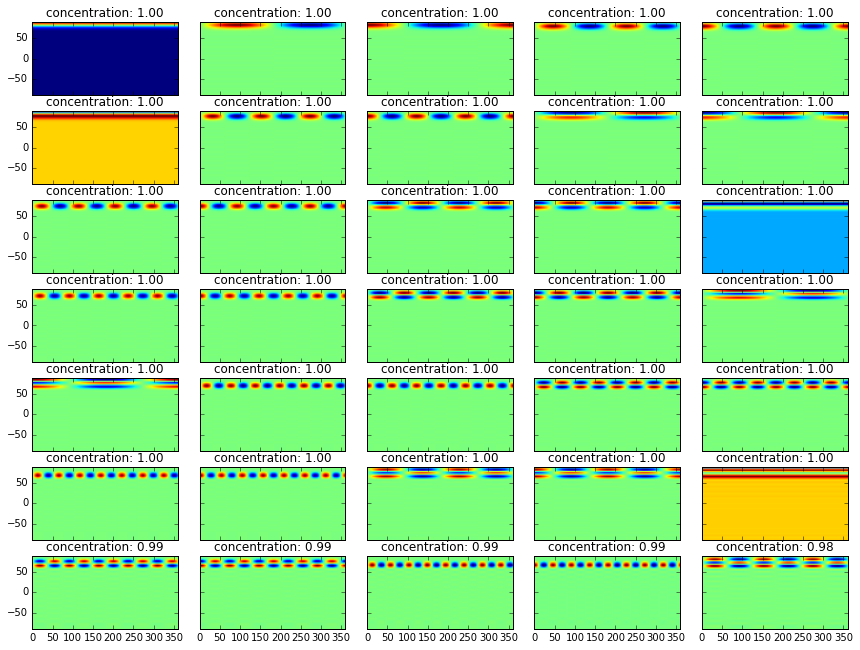

In [31]:
fig, axes = scapwin.plot_windows(35)

As is seen, the windows are centered at the north pole. The concentration factor is noted above the window, and almost all of these windows are very well localized. If you want to know how many windows have concentration factors larger than a specified value, you can use the method `get_k()`:

In [32]:
scapwin.get_k(0.99)

34

If you are really curious about the windows, you can return gridded maps of individual windows using the methods `get_grid()` and `return_grid()`, you can return the spherical harmonic coefficients of individual windows using `get_coeffs()` and `return_coeffs()`, and you can also return as a numpy array the power spectrum of one or more windows using the method `get_powerperdegree()`. If you want to plot the power spectra of the windows, this can be done using the built in method `plot_powerperdegree()`:

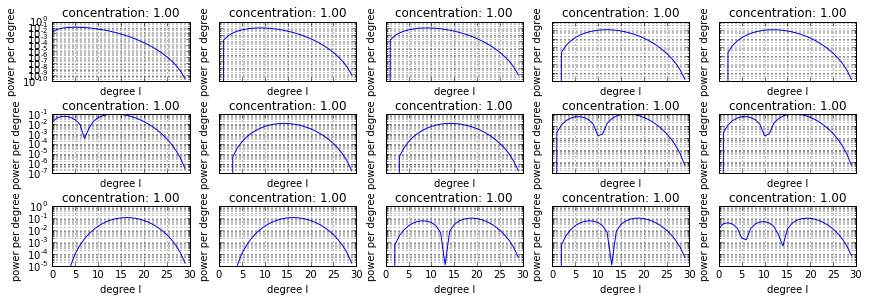

In [33]:
fig, axes = scapwin.plot_powerspectra(15)

In general, we will not perform localized spectral analyses at the north pole, so lets rotate the windows so that they are centered at 45 degrees north and 90 east. This is easily accomplished using the `rotate()` method:

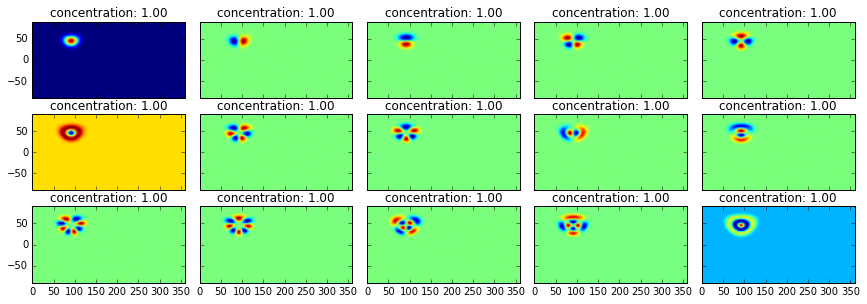

In [34]:
scapwin.rotate(clat=45., clon=90.)

fig, axes = scapwin.plot_windows(15)

In rotating the windows, the spherical harmonic coefficients of the initial `tapers` centered at the north pole are not modified, and a second set of rotated coefficients are created and stored in the attribute `coeffs`. If you ever forget how you constructed your windows, you can always use the `info()` method to print out all the metadata:

In [35]:
scapwin.info()

kind = 'cap'
theta = 30.000000 degrees
lwin = 29
nwin = 900
clat = 45.000000 degrees
clon = 90.000000 degrees
dj_matrix is stored
Taper weights are not set.


Next, let's calculate the localized power spectrum at two different locations, one in the northern hemisphere and the other in the southern hemisphere. We will use all 34 windows that have concentration factors greater than 0.99:

In [36]:
k = scapwin.get_k(0.99)

mtse_north, sd_north = scapwin.get_multitaperpowerspectrum(clm, k)
mtse_south, sd_south = scapwin.get_multitaperpowerspectrum(clm, k, clat=-55., clon=90.)

If you don't provide the central latitude and longitude of the analysis with the parameters `clat` and `clon`, the coefficients that were created previously using the `rotate()` method will be employed. If these coefficients are not available, the analysis will be performed at the north pole.

This function returns a power spectrum whose maximum degree is `ldata - lwin`. This is because localized degrees beyond this limit depend upon coefficients of the global data beyond `ldata`, and these are **not known**. If the global function is truly zero beyond `ldata`, simply construct the spherical harmonic coefficients of `clm` to have zeros beyond that degree.

When a function is multiplied by a window, the power spectrum of the localized function is modified. For the case of stationary and random data, the expectation of this biasing effect can be estimated using the method `get_biasedpowerspectrum()`. This can also be quantified by calculating the "coupling matrix" using the method `get_couplingmatrix()`. With this second approach, the output power spectrum is simply calculated as the multiplication of this matrix by the input spectrum. If you are interested, you can plot the coupling matrix using the built in method `plot_couplingmatrix()`:

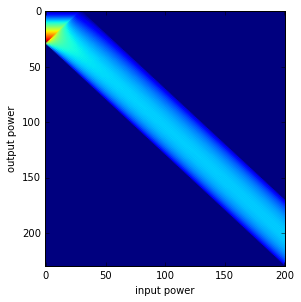

In [37]:
fig, ax = scapwin.plot_couplingmatrix(ldata)

Here, however, we will estimate the expectation of the windowed spectrum using `get_biasedpowerspectrum()` and the global power spectra of the northern and southern hemispheres.

In [38]:
power_north_biased = scapwin.get_biasedpowerspectrum(power_north, k)
power_south_biased = scapwin.get_biasedpowerspectrum(power_south, k)

Note that this function returns a spectrum with a maximum degree `ldata+lwin`. In calculating this, it is assumed implicitly that the global power spectrum is exactly zero for all degrees greater than `ldata`.

Finally, lets plot the global power spectra, the localized spectra, and the localized expectations.

[None,
 (1e-06, 1.0),
 (0, 200),

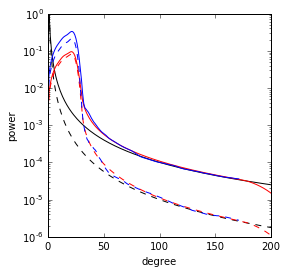

In [39]:
degrees2 = np.arange(ldata+scapwin.lwin+1)
degrees3 = np.arange(ldata-scapwin.lwin+1)

fig, ax = plt.subplots(1,1)
ax.plot(degrees, power_north, '-k', degrees, power_south, '--k', degrees2, power_north_biased, '-r', degrees2, power_south_biased, '--r', degrees3, mtse_north, '-b', degrees3, mtse_south, '--b')
ax.set(yscale='log', xlabel='degree', ylabel='power', xlim=(0,200), ylim=(1.e-6, 1.))

As is seen, the expectation of the localized spectrum is significantly biased at low degrees in comparison to the unwindowed global fields. This is not necessarily a problem, because this effect is quantifiable. The localized power spectrum using 34 windows is found to closely resemble the expected value. 

In this example, we calculated only the localized power spectrum of a single function. If you were interested in the localized cross-power spectrum of two functions, this could be caluculated using the method `get_multitapercrosspowerspectrum()`.